# LIME vs SHAP
## for explaining classifiers in machine learning models

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [16]:
data = pd.read_csv('data/train.csv')
print(data.shape)

(25000, 65)


In [17]:
data.head()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                14                  41               0               11   
1                 2                  30               0               12   
2                 5                  66               0               22   
3                 3                  63               0                8   
4                 5                  40               0                6   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
0                  0                 0                 0                 6   
1                  0                 0                 1                 9   
2                  1                 0                 2                 9   
3                  0                 0                 0                 8   
4                  0                 0                 1                 9   

   race_Caucasian  race_AfricanAmerican  ...  citoglipton_No  insulin_No  \
0            True                 False  ...            True        True   
1            True                 False  ...            True       False   
2            True                 False  ...            True        True   
3            True                 False  ...            True        True   
4            True                 False  ...            True        True   

   glyburide-metformin_No  glipizide-metformin_No  \
0                    True                    True   
1                    True                    True   
2                    True                    True   
3                    True                    True   
4                    True                    True   

   glimepiride-pioglitazone_No  metformin-rosiglitazone_No  \
0                         True                        True   
1                         True                        True   
2                         True                        True   
3                         True                        True   
4                         True                        True   

   metformin-pioglitazone_No  change_No  diabetesMed_Yes  readmitted  
0                       True       True             True           0  
1                       True      False             True           1  
2                       True       True             True           1  
3                       True       True             True           1  
4                       True       True            False           0  

[5 rows x 65 columns]

Data to predict is "readmitted" (prediction target)

In [18]:
y = data.readmitted[0:2000]

base_features = [c for c in data.columns if c != "readmitted"]

x = data.iloc[0:2000, 0:60].astype(int)
x.head()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                14                  41               0               11   
1                 2                  30               0               12   
2                 5                  66               0               22   
3                 3                  63               0                8   
4                 5                  40               0                6   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
0                  0                 0                 0                 6   
1                  0                 0                 1                 9   
2                  1                 0                 2                 9   
3                  0                 0                 0                 8   
4                  0                 0                 1                 9   

   race_Caucasian  race_AfricanAmerican  ...  acarbose_No  miglitol_No  \
0               1                     0  ...            1            1   
1               1                     0  ...            1            1   
2               1                     0  ...            1            1   
3               1                     0  ...            1            1   
4               1                     0  ...            1            1   

   troglitazone_No  tolazamide_No  examide_No  citoglipton_No  insulin_No  \
0                1              1           1               1           1   
1                1              1           1               1           0   
2                1              1           1               1           1   
3                1              1           1               1           1   
4                1              1           1               1           1   

   glyburide-metformin_No  glipizide-metformin_No  glimepiride-pioglitazone_No  
0                       1                       1                            1  
1                       1                       1                            1  
2                       1                       1                            1  
3                       1                       1                            1  
4                       1                       1                            1  

[5 rows x 60 columns]

In [19]:
rnd = 23
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.25, stratify=y, random_state=rnd)

clss = RandomForestClassifier(max_depth=4, random_state=rnd).fit(train_x, train_y)


sample_num = 1
test_sample = val_x.iloc[sample_num, :]

## Feature importance - without LIME or SHAP

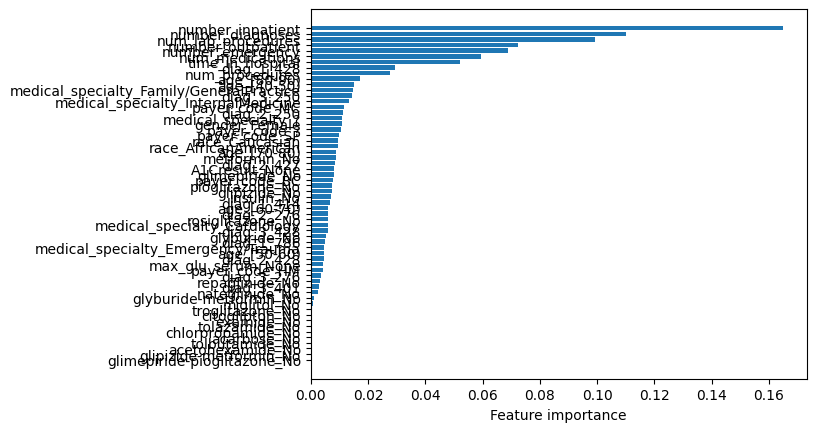

In [20]:
# feature importance df
imp_df = pd.DataFrame({'feature': train_x.columns.values, 'importance': clss.feature_importances_})

# reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1, len(imp_df.index) + 1)

# barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# horizontal bars
plt.barh(y_pos, height)

# names on y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Feature importance")

plt.show()

## Outcome of test sample

Random forest prediction for smple 1 = [0.40326686 0.59673314]
Actual outcome =  1


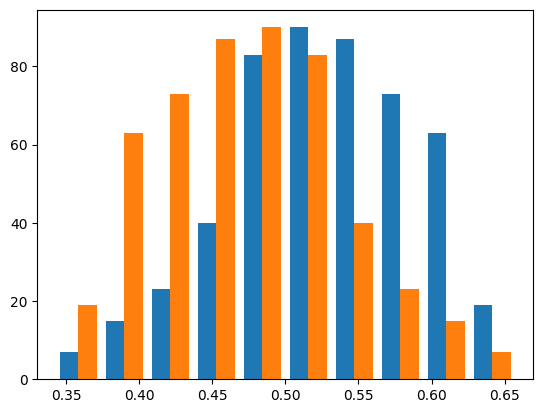

In [21]:
out = clss.predict_proba(val_x)
plt.hist(out)

print("Random forest prediction for smple", sample_num, '=', out[sample_num])
print("Actual outcome = ", val_y.iloc[sample_num])

## Visualization using LIME

In [22]:
import lime
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(training_data=train_x.values, feature_names=train_x.columns,
                                                   class_names=['No_Readmission', 'Yes_Readmission'], mode='classification', verbose=True, random_state=rnd)

lime_exp = lime_explainer.explain_instance(data_row=test_sample, predict_fn=clss.predict_proba, num_features=20)

Intercept 0.4492411207894519
Prediction_local [0.5648048]
Right: 0.596733136434143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


-> probability of 1 is ~0.56 (same as randomforestclassification)

&nbsp;&nbsp;&nbsp;&nbsp;=> but how is the model coming to its conclusion?

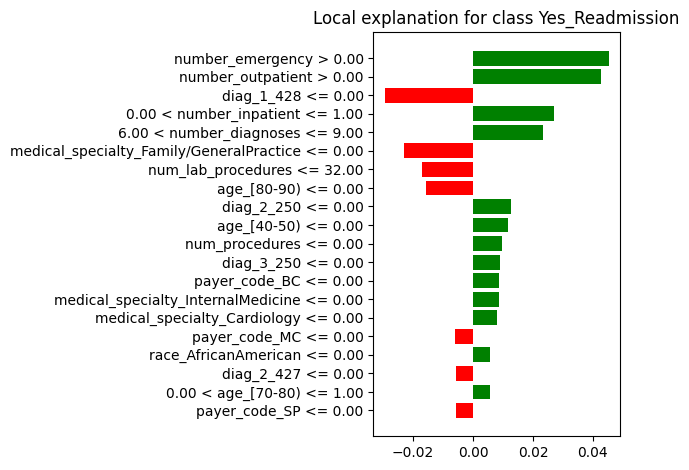

In [23]:
# plot
plt = lime_exp.as_pyplot_figure()
plt.tight_layout()

green -> positive correlations to Yes_Readmission

red   -> negative correlations

In [24]:
lime_exp.show_in_notebook(show_table=True, show_all=False)

## SHAP

In [25]:
import shap

explainer = shap.TreeExplainer(clss)

shap_values = explainer.shap_values(val_x)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:],test_sample)

In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], val_x)

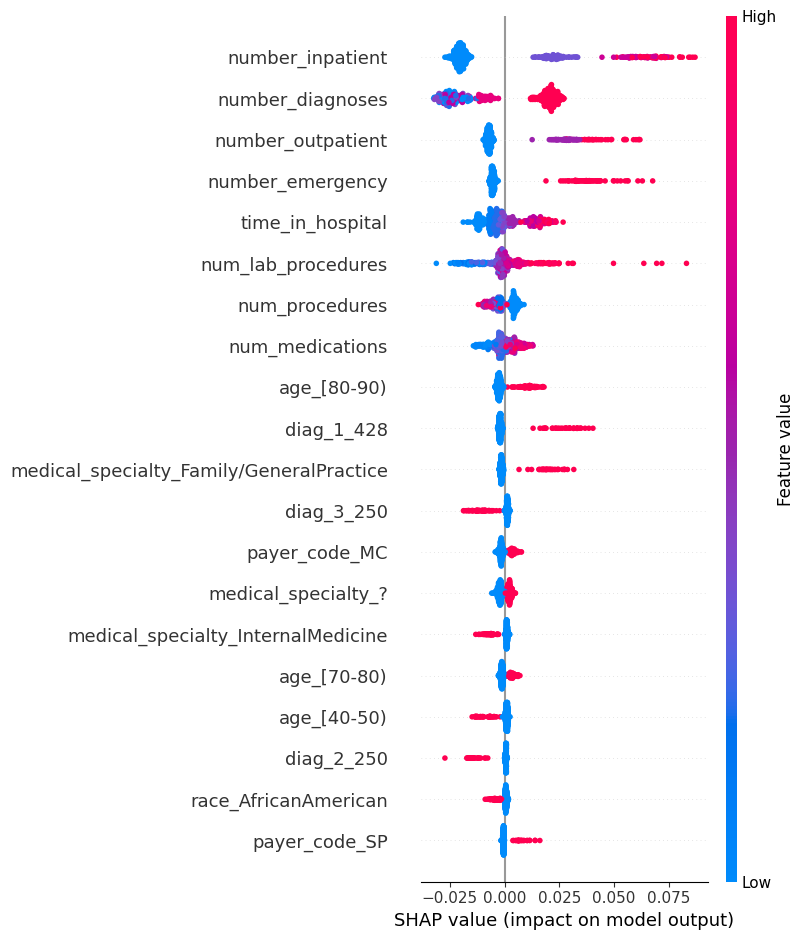

In [30]:
shap.summary_plot(shap_values[1], val_x)